In [2]:
import os, sys
import time
import numpy as np
import pandas as pd
import yaml
import h5py
import pickle
import configparser
import argparse
import matplotlib.pyplot as plt

## Data preprocessing - logNorm transformation

In [3]:
if __name__ == "__main__":

    start = time.time()
    print('\nSTART PROCESSING')
    
    met_model = 'varma_ecoli_small'
    exp_id = 'fdp1'
    
    # get back parameters
    #path_parameters = f'models/{met_model}/parameters/parameters_sample_id_{exp_id}_0.hdf5'
    path_parameters = 'models/varma_ecoli_small/parameters/parameters_sample_id_fdp1_0.hdf5'
    if not path_parameters.endswith('.hdf5'):
        raise ValueError('Your data must be a .hdf5 file')

    # get back the stability information
    #path_stability = f'models/{met_model}/parameters/maximal_eigenvalues_{exp_id}_0.csv'
    path_stability = 'models/varma_ecoli_small/parameters/maximal_eigenvalues_fdp1.csv'
    if not path_stability.endswith('.csv'):
        raise ValueError('Your data must be a .csv file')

    # get the data and processed
    f = h5py.File(path_parameters, 'r')
    stabilities = pd.read_csv(path_stability).iloc[:,1].values
    parameter_set_dim = 411
    
    n_parameters = f[('num_parameters_sets')][()]
    all_data = np.empty([n_parameters, parameter_set_dim])
    all_stabilities = np.empty([n_parameters])

    J_partition = -9
    count0,count1 = 0,0
    
    for i in range(0,n_parameters):
        
        if i%10000==0:
            print(f'current set processed: {i}')
        this_param_set = f'parameter_set_{i}'
        param_values = np.array(f.get(this_param_set))

        mreal = stabilities[i]
        
        if mreal>=J_partition:
            stability=0
            count0+=1
        elif mreal<J_partition:
            stability=1
            count1+=1
            
        all_data[i]=param_values
        all_stabilities[i] = stability

    all_data = np.array(all_data)
    all_stabilities = np.array(all_stabilities)
    
    n_param = all_data.shape[0]
    print(f'Desired Stability Incidence: {count1/n_param}')

    # keep only km
    parameter_names = list(f['parameter_names'])
    idx_to_keep = [i for i,x in enumerate(parameter_names) if 'km_' in x]
    all_km = all_data[:,idx_to_keep]
    all_km_names = [x for i,x in enumerate(parameter_names) if 'km_' in x]
    
    #create control dataset
    control_samples = 5000
    control_data = np.empty((control_samples,all_km.shape[1]))
    range_all_km = np.empty((2,all_km.shape[1]))
    for j in range(all_km.shape[1]):
        range_all_km[:,j] = np.array([np.min(all_km[:,j]),np.max(all_km[:,j])])

    for j in range(control_samples):
        this_control = []
        for k in range(all_km.shape[1]):
            this_km = np.random.uniform(range_all_km[0][k], range_all_km[1][k])
            this_control.append(this_km)
        control_data[j,:] = this_control

    print(f'Shape of all data: {all_km.shape}')
    print(f'Shape of control data: {control_data.shape}')
    
    # take the log
    log_all_data = np.log(all_km)

    # train-val split
    ratio = float(0.8)
    n_data = log_all_data.shape[0]
    limit = int(ratio*n_data)
    all_idx = np.arange(n_data)
    np.random.shuffle(all_idx)

    idx_tr = all_idx[:limit]
    idx_val = all_idx[limit:]

    tr_data = log_all_data[idx_tr]
    val_data = log_all_data[idx_val]

    tr_stabi = all_stabilities[idx_tr]
    val_stabi = all_stabilities[idx_val]

    print(f'N data for training: {tr_data.shape[0]}')
    print(f'N data for validation: {val_data.shape[0]}')



START PROCESSING
current set processed: 0
current set processed: 10000
current set processed: 20000
current set processed: 30000
current set processed: 40000
current set processed: 50000
current set processed: 60000
current set processed: 70000
Desired Stability Incidence: 0.588125
Shape of all data: (80000, 259)
Shape of control data: (5000, 259)
N data for training: 64000
N data for validation: 16000


# 1. Logistic Regression

In [4]:
from sklearn.linear_model import LogisticRegression

## Checking classification performance

In [5]:
store_accuracy_lr = []
store_importance_lr = []
for j in range(10):
    clf = LogisticRegression(solver = 'lbfgs', max_iter=100).fit(tr_data, tr_stabi)

    # Predict labels on Test data
    pred = clf.predict(val_data)
    accuracy_lr  = len([boolean for boolean in (pred == val_stabi) if boolean==True])/len(val_stabi) 
    store_accuracy_lr.append(accuracy_lr)
    store_importance_lr.append(clf.coef_[0])
    
store_accuracy_lr = np.array(store_accuracy_lr)
print(f'Logistic Regression performance : {np.mean(store_accuracy_lr)}. with error: {np.std(store_accuracy_lr)}')

Logistic Regression performance : 0.7344375000000001. with error: 1.1102230246251565e-16


## Check feature importance

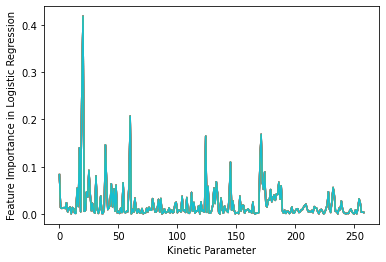

In [6]:
plt.plot(np.abs(np.array(store_importance_lr)).T)
plt.xlabel('Kinetic Parameter')
plt.ylabel('Feature Importance in Logistic Regression')
plt.show()

In [7]:
mean_score_lr = np.mean(np.abs(store_importance_lr), axis = 0)
imp_idx = np.where(mean_score_lr == np.max(mean_score_lr))[0][0]
print(f'Most important feature according to Logistic Regression coefficients: {parameter_names[imp_idx]}')

Most important feature according to Logistic Regression coefficients: km_substrate_ACONTa


## Pruning feautures which have high feature importance and repeating

In [8]:
imp_idxs =  np.where(mean_score_lr >= 0.1)[0]
store_accuracy_lr_pruned = []
store_importance_lr_pruned = []
for j in range(10):
    clf = LogisticRegression(solver = 'lbfgs', max_iter=100).fit(tr_data[:,imp_idxs], tr_stabi)

    # Predict labels on Test data
    pred = clf.predict(val_data[:,imp_idxs])
    accuracy_lr  = len([boolean for boolean in (pred == val_stabi) if boolean==True])/len(val_stabi) 
    store_accuracy_lr_pruned.append(accuracy_lr)
    store_importance_lr_pruned.append(clf.coef_[0])
    
store_accuracy_lr_pruned = np.array(store_accuracy_lr_pruned)
print(f'Logistic Regression performance on pruned dataset : {np.mean(store_accuracy_lr_pruned)}. with error: {np.std(store_accuracy_lr_pruned)}')

Logistic Regression performance on pruned dataset : 0.7113750000000001. with error: 1.1102230246251565e-16


We observe that pruning the most important features did not result in improved classification and hence they are not reliable estimators of important kinetic parameters

# 2. Support Vector Machines

In [9]:
from sklearn import svm

In [10]:
store_accuracy_svm = []
for j in range(3):
    clf = svm.SVC()
    clf.fit(tr_data, tr_stabi)
    pred_svm = clf.predict(val_data)
    accuracy_svm  = len([boolean for boolean in (pred_svm == val_stabi) if boolean==True])/len(val_stabi)
    store_accuracy_svm.append(accuracy_svm)

store_accuracy_svm= np.array(store_accuracy_svm)
print(f'Support vector machine performance : {np.mean(store_accuracy_svm)}. with error: {np.std(store_accuracy_svm)}')

Support vector machine performance : 0.741625. with error: 0.0


Classification with SVMs is also not very good. 

# 3. XGboost

In [13]:
!pip install xgboost
import xgboost
from xgboost import XGBClassifier

  Using cached xgboost-1.6.0-py3-none-manylinux2014_x86_64.whl (193.7 MB)


In [14]:
store_accuracy_xgb= []

for j in range(5):
    
    model=XGBClassifier(learning_rate=0.01)
    model.fit(tr_data, tr_stabi)
    
    pred_xgb = model.predict(val_data)
    accuracy_xgb  = len([boolean for boolean in (pred_xgb == val_stabi) if boolean==True])/len(val_stabi)
    store_accuracy_xgb.append(accuracy_xgb)

store_accuracy_xgb = np.array(store_accuracy_xgb)
print(f'XGBoost performance : {np.mean(store_accuracy_xgb)}. with error: {np.std(store_accuracy_xgb)}')

XGBoost performance : 0.7595. with error: 0.0


## Important features

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

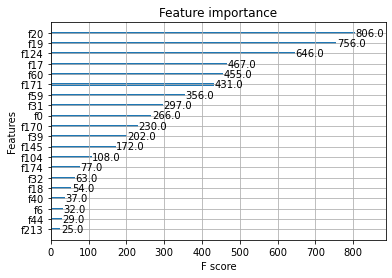

In [15]:
xgboost.plot_importance(model, max_num_features = 20)

## Pruning important features

In [16]:
imp_features = [19,20,124,171,17,60,59,31,170,0,39,145,104,18,174,32,12,172,1,44]

store_accuracy_xgb_pruned= []

for j in range(5):
    
    model=XGBClassifier(learning_rate=0.01)
    model.fit(tr_data[:,imp_features], tr_stabi)
    
    pred_xgb = model.predict(val_data[:,imp_features])
    accuracy_xgb_pruned  = len([boolean for boolean in (pred_xgb == val_stabi) if boolean==True])/len(val_stabi)
    store_accuracy_xgb_pruned.append(accuracy_xgb_pruned)

store_accuracy_xgb = np.array(store_accuracy_xgb_pruned)
print(f'XGBoost performance after pruning: {np.mean(store_accuracy_xgb_pruned)}. with error: {np.std(store_accuracy_xgb_pruned)}')

XGBoost performance after pruning: 0.759875. with error: 0.0


# 4. Random Forests

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
store_accuracy_rf = []
for j in range(3):
    clf = RandomForestClassifier(max_depth=2)
    clf.fit(tr_data, tr_stabi)
    pred_rf = clf.predict(val_data)
    accuracy_rf  = len([boolean for boolean in (pred_rf == val_stabi) if boolean==True])/len(val_stabi)
    store_accuracy_rf.append(accuracy_rf)

store_accuracy_rf = np.array(store_accuracy_rf)
print(f'Random Forest performance : {np.mean(store_accuracy_rf)}. with error: {np.std(store_accuracy_rf)}')

Random Forest performance : 0.5899166666666666. with error: 0.0008559432743405849


# Summary

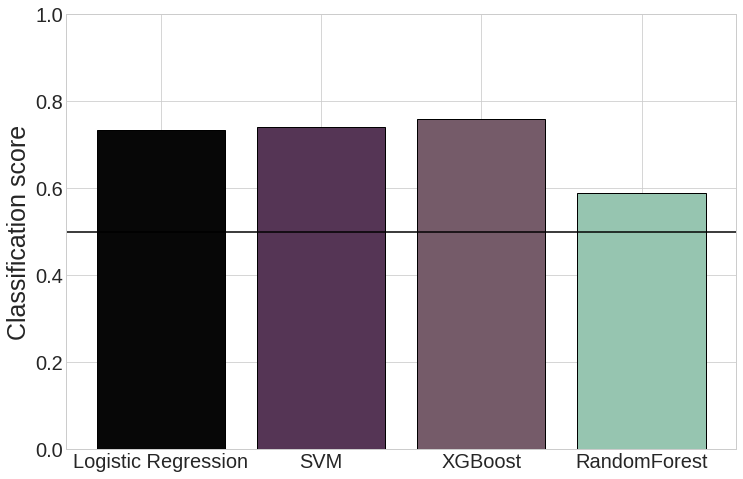

In [34]:
all_results = [np.mean(store_accuracy_lr),
               np.mean(store_accuracy_svm),
               np.mean(store_accuracy_xgb),
               np.mean(store_accuracy_rf)]
labels = ['Logistic Regression', 'SVM', 'XGBoost', 'RandomForest']
c = ['#070707','#553555', '#755B69', '#96C5B0']
plt.figure(figsize = (12,8))
plt.bar(labels,all_results, edgecolor= 'k', linewidth = '1', color = c)
plt.ylim([0,1])
plt.axhline(y=0.5, c= 'k')
plt.ylabel('Classification score')

plt.savefig('simpler_models.svg', dpi=300, 
                 transparent=False, bbox_inches='tight')
plt.show()

In [33]:
np.set_printoptions(precision=2)

plt.rcParams['axes.labelsize'] = 25
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.style.use('seaborn-whitegrid')
#plt.style.use('science')
%matplotlib inline